# Day 23

## Part 1

- Let's plant some seeds!
- North is up
- the grove extends out a long way in all directions from the scanned area
- the elves alternate between considering where to move and moving each round
     - first half: consider the 8 positions adjacent.
        - if no other elves are present, this elf does nothing. If not:
        1. if no elves N, NE, NW: move N
        1. if no elves S, SE, SW: move S
        1. if no elves W, NW, SW: move W
        1. if no elves E, NE, SE: move E
     - second half:
        - all elves move to their proposed positions provided they are the only elf trying to go there.
        - if more than one elf wants to go to a position, neither move
    - end half:
        - The order of the direction check above cycles so over 4 rounds:
            1. N, S, W, E
            1. S, W, E, N
            1. W, E, N, S
            1. E, N, S, W
            1. back to 1.
- stop after 10 rounds
- find the smallest bounding rectangle for the elves at this point and sum the number of empty ground tiles

`How many ground tiles does that rectangle contain?`

In [51]:
from copy import deepcopy
from itertools import cycle
import numpy as np
from matplotlib import pyplot as plt
from utils import ParseConfig, parse_from_file

parser = ParseConfig('\n', ParseConfig('', str))

grove = parse_from_file('day_23.txt', parser)

print(grove[0][:10])

['#', '.', '.', '.', '#', '#', '#', '#', '.', '.']


In [52]:
# it will be easier to manage an ever growing grid by just storing each elf
# by location
starting_elves = []
for y, rowve in enumerate(grove):
    for x, patch in enumerate(rowve):
        if patch == '#':
            starting_elves.append((x, y))

print(starting_elves[:10])

[(0, 0), (4, 0), (5, 0), (6, 0), (7, 0), (11, 0), (13, 0), (14, 0), (16, 0), (17, 0)]


Text(0.5, 1.0, 'The elves begin to rove the grove')

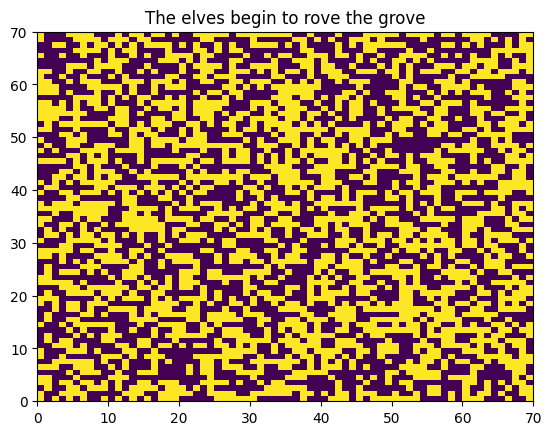

In [53]:
# we still want to be able to make nice plots though so let's make a func to
# convert it back
def elves_to_grid(elves: list[tuple[int]]) -> np.ndarray:
    """
    returns a 2-D array of grove
    """
    ground = 0
    elf = 1
    min_x, max_x = min([x for x, _ in elves]), max([x for x, _ in elves])
    min_y, max_y = min([y for _, y in elves]), max([y for _, y in elves])
    grid = []
    for _ in range(max_y - min_y + 1):
        grid.append([])
        for __ in range(max_x - min_x + 1):
            grid[-1].append(ground)
    for x, y in elves:
        grid[y - min_y][x - min_x] = elf
    return np.array(grid)

grid = elves_to_grid(starting_elves)
fig, ax = plt.subplots()
ax.pcolormesh(list(reversed(grid)))
ax.set_title('The elves begin to rove the grove')

In [54]:
# define directions as coordinate offsets
N = (0, -1)
NE = (1, -1)
E = (1, 0)
SE = (1, 1)
S = (0, 1)
SW = (-1, 1)
W = (-1, 0)
NW = (-1, -1)

adjacent_offsets = [N, NE, E, SE, S, SW, W, NW]

check_order = [N, S, W, E]

check_offsets = {
    N: [N, NE, NW],
    S: [S, SE, SW],
    W: [W, NW, SW],
    E: [E, NE, SE]
}

def adjacent_elves(elf: tuple[int], elves: list[tuple[int]]) -> dict:
    """
    returns a dictionary of directions and if there is an elf in that direction
    """
    ex, ey = elf
    adjacent = {}
    for ox, oy in adjacent_offsets:
        adjacent.update({(ox, oy): (ex + ox, ey + oy) in elves})
    return adjacent

In [55]:
elves = deepcopy(starting_elves)

snapshots = [starting_elves]
check_order_cycle = cycle(check_order)
# ok let's simulate the grove!
for iteration in range(1, 10 + 1):
    check_directions = [
        direction for _, direction in zip(check_order, check_order_cycle)]
    # first let's figure out where everyone wants to go
    proposed_moves = []
    for elf in elves:
        adjacent = adjacent_elves(elf, elves)
        # first check if there are any elves around this one
        if not any([is_full for is_full in adjacent.values()]):
            proposed_moves.append(None)
            continue
        # now check each direction
        proposed_position = None
        ex, ey = elf
        for direction in check_directions:
            if all([
                not adjacent[offset] for offset in check_offsets[direction]
            ]):
                proposed_position = tuple([
                    value + offset for value, offset in zip(elf, direction)])
            if proposed_position is not None:
                break
        # since only 2 elves can want to go to the same spot (because of they
        # check diagonals)
        # if another elf isn't already trying to go there add it
        if proposed_position not in proposed_moves:
            proposed_moves.append(proposed_position)
        # if they are, both moves should be set to None
        else:
            proposed_moves[proposed_moves.index(proposed_position)] = None
            proposed_moves.append(None)
    # second, enact moves
    new_elves = []
    for stay, move in zip(elves, proposed_moves):
        if move is not None:
            new_elves.append(move)
        else:
            new_elves.append(stay)
    elves = new_elves
    snapshots.append(deepcopy(new_elves))
    # tick forward the check cycle
    next(check_order_cycle)

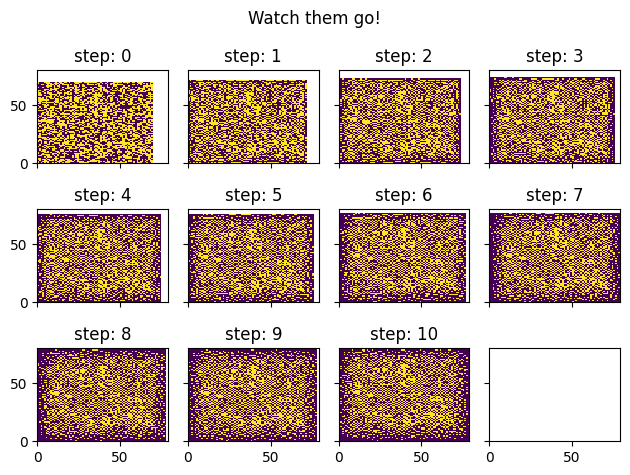

In [56]:
fig, _ = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True)
count = 0
for ax, snapshot in zip(fig.axes, snapshots):
    ax.pcolormesh(list(reversed(elves_to_grid(snapshot))))
    ax.set_title(f'step: {count}')
    count += 1
fig.suptitle('Watch them go!')
fig.tight_layout()

In [62]:
final_snapshot = elves_to_grid(snapshots[10])

total_area = len(final_snapshot) * len(final_snapshot[0])
total_ground = total_area - len(elves)

print(f'the total exposed ground in the bounding rectangle is {total_ground}!')

the total exposed ground in the bounding rectangle is 3874!


## Part 2

`What is the number of the first round where no Elf moves?`

In [58]:
iteration = 10
keep_iterating = True
while keep_iterating:
    iteration += 1
    print(f'iteration: {iteration}', end='\r')
    check_directions = [
        direction for _, direction in zip(check_order, check_order_cycle)]
    # first let's figure out where everyone wants to go
    proposed_moves = []
    for elf in elves:
        adjacent = adjacent_elves(elf, elves)
        # first check if there are any elves around this one
        if not any([is_full for is_full in adjacent.values()]):
            proposed_moves.append(None)
            continue
        # now check each direction
        proposed_position = None
        ex, ey = elf
        for direction in check_directions:
            if all([
                not adjacent[offset] for offset in check_offsets[direction]
            ]):
                proposed_position = tuple([
                    value + offset for value, offset in zip(elf, direction)])
            if proposed_position is not None:
                break
        # since only 2 elves can want to go to the same spot (because of they
        # check diagonals)
        # if another elf isn't already trying to go there add it
        if proposed_position not in proposed_moves:
            proposed_moves.append(proposed_position)
        # if they are, both moves should be set to None
        else:
            proposed_moves[proposed_moves.index(proposed_position)] = None
            proposed_moves.append(None)
    # second, enact moves
    new_elves = []
    for stay, move in zip(elves, proposed_moves):
        if move is not None:
            new_elves.append(move)
        else:
            new_elves.append(stay)
    elves = new_elves
    snapshots.append(deepcopy(new_elves))
    # tick forward the check cycle
    next(check_order_cycle)
    # check if we can stop
    keep_iterating = any([move is not None for move in proposed_moves])

...that only took 18 minutes


Text(0.5, 1.0, 'finally some space to stretch!')

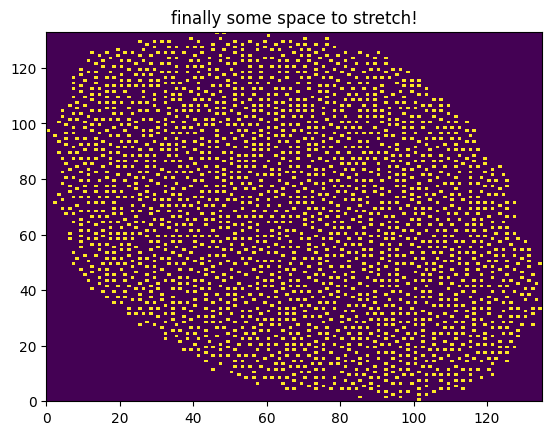

In [60]:
print('...that only took 18 minutes')
grid = elves_to_grid(elves)
fig, ax = plt.subplots()
ax.pcolormesh(list(reversed(grid)))
ax.set_title('finally some space to stretch!')

In [63]:
print(f'the total rounds taken to spread out is: {iteration}')

the total rounds taken to spread out is: 948


In [65]:
# save the snapshots
with open('snapshots.txt', 'w') as file:
    file.write('\n'.join(str(snapshots)))
    file.write('\n')